In [1]:
import re
import pickle
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from nltk.stem import WordNetLemmatizer

In [4]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
df = pd.read_csv('/Users/kumarmayank/data/tsa.csv',
                      encoding='ISO-8859-1' , names=["sentiment", "ids", "date", "flag", "user", "text"])


In [6]:
df

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


/var/folders/rw/z1h7_zz967sf8xy_601yr3cw0000gn/T/ipykernel_5097/4026484813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace(4,1)


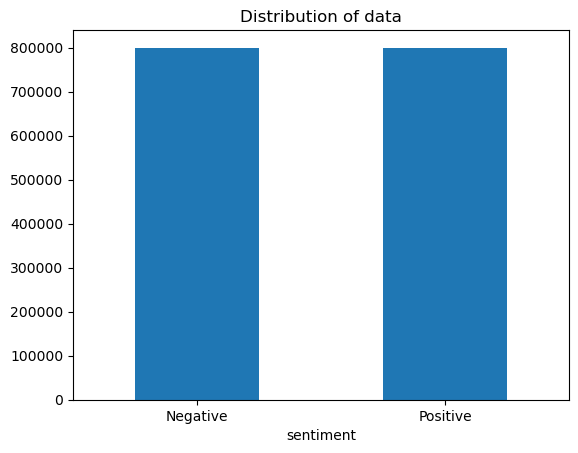

In [7]:
# Removing the unnecessary columns.
df = df[['sentiment','text']]
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

In [8]:
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [10]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [11]:
processed_text = preprocess(text)

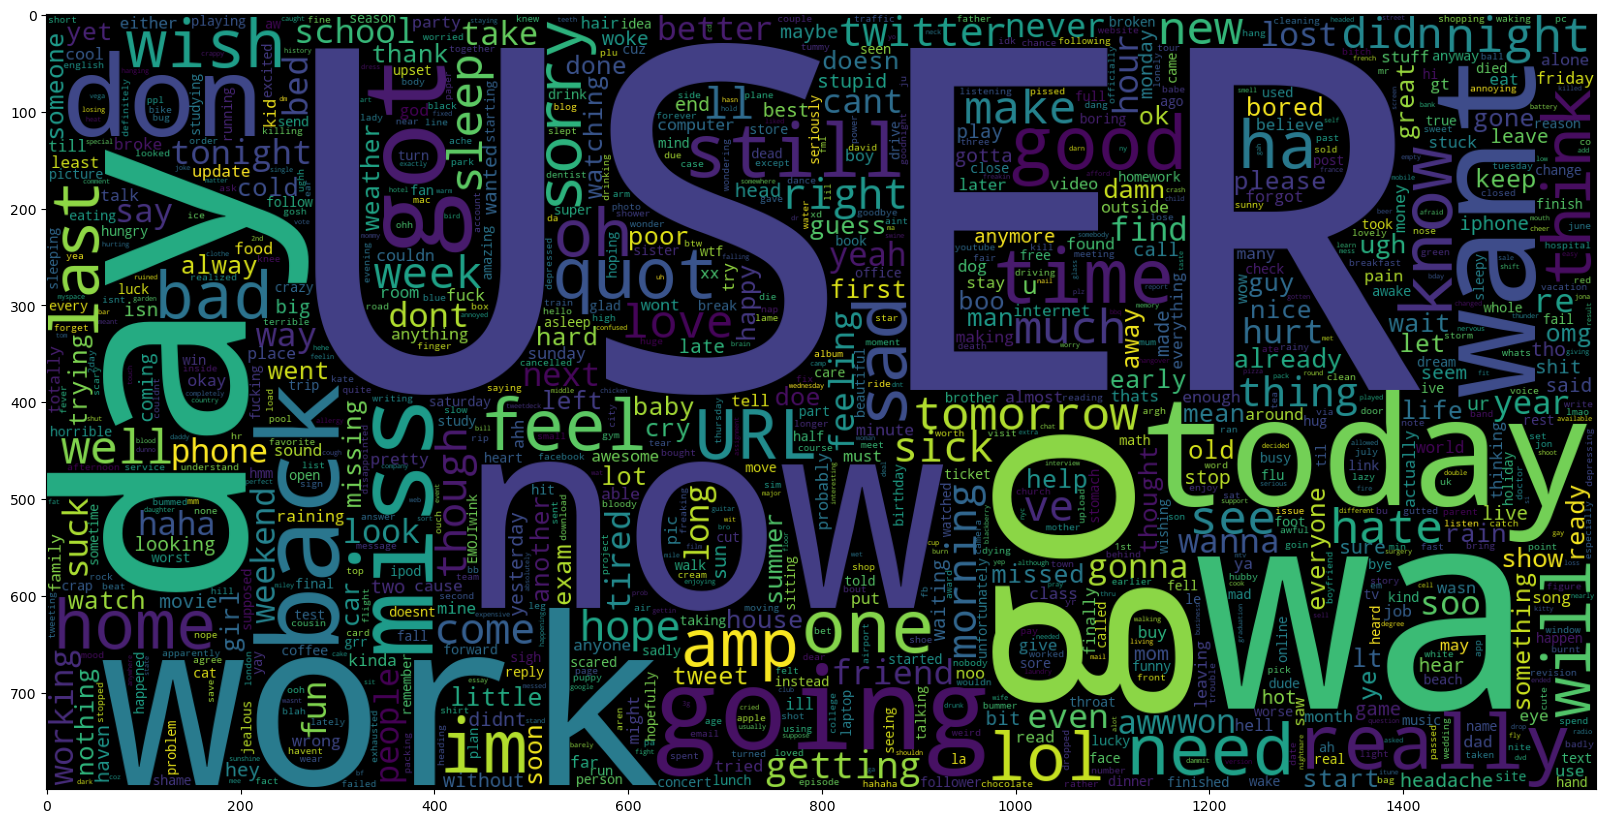

In [12]:
negative_tweets = processed_text[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative_tweets))
plt.imshow(wc)

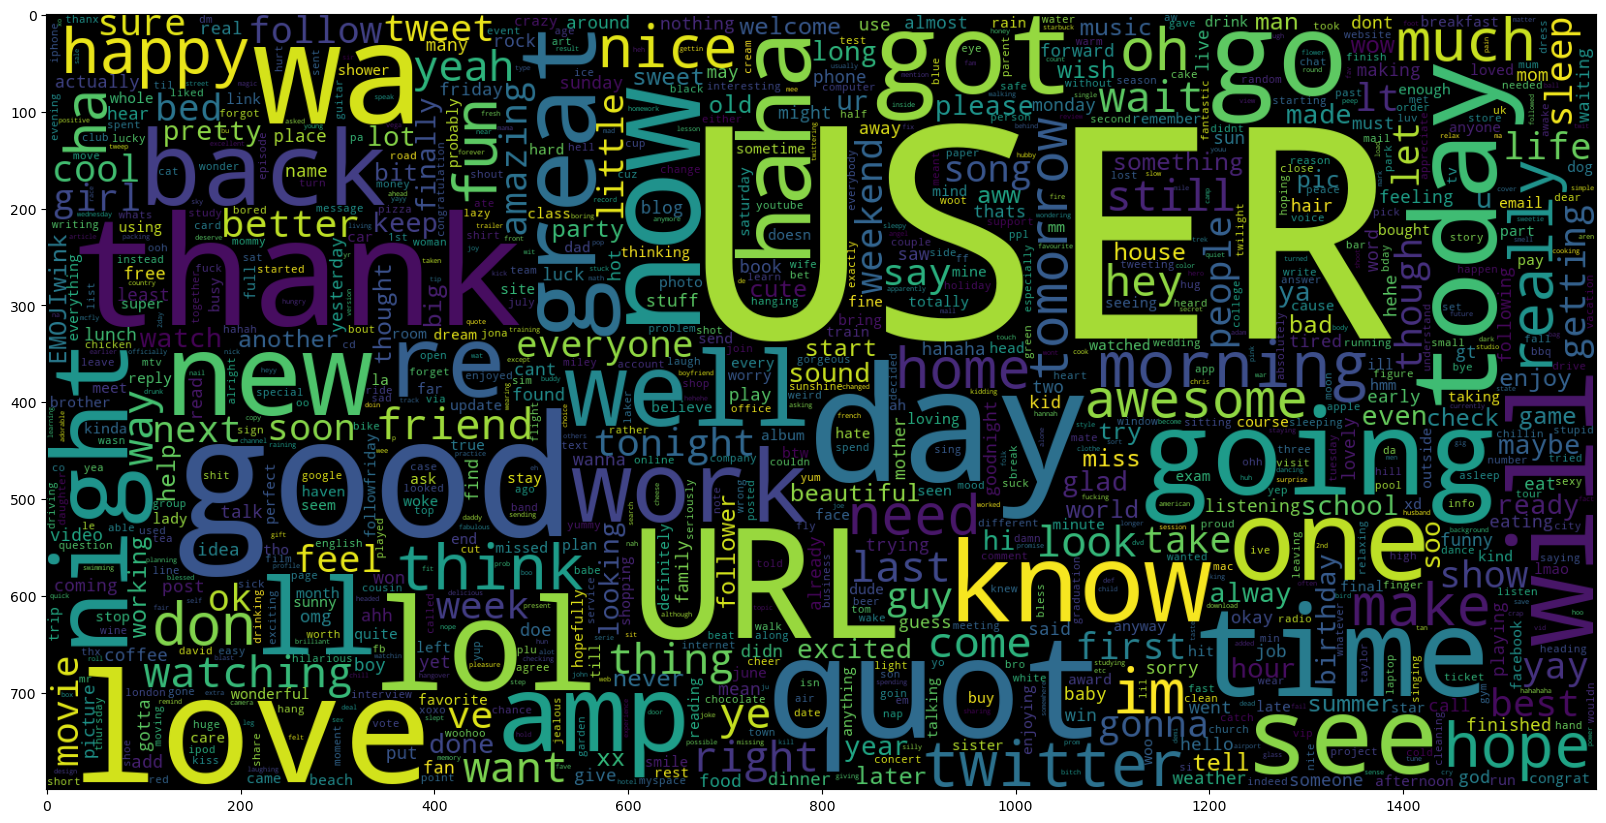

In [13]:
positive_tweets = processed_text[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(positive_tweets))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment,
                                                    test_size = 0.05, random_state = 0)

In [15]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [16]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [25]:
from sklearn.metrics import accuracy_score

In [27]:
def modelvaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Accuracy Score:
    print("Accuracy Score:",accuracy_score(y_test,y_pred))
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Accuracy Score: 0.8018625
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



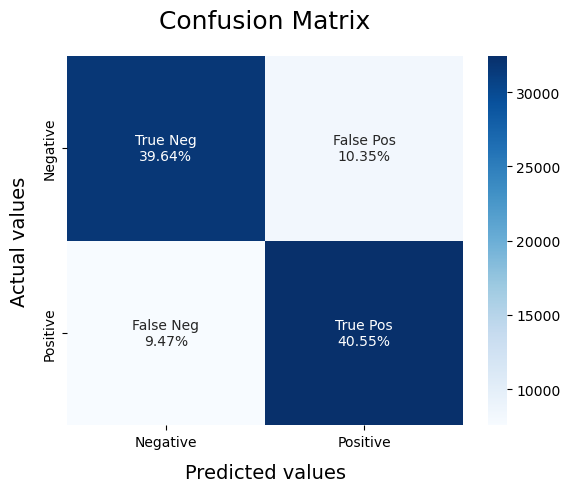

In [28]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
modelvaluate(BNBmodel)

Accuracy Score: 0.8184375
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



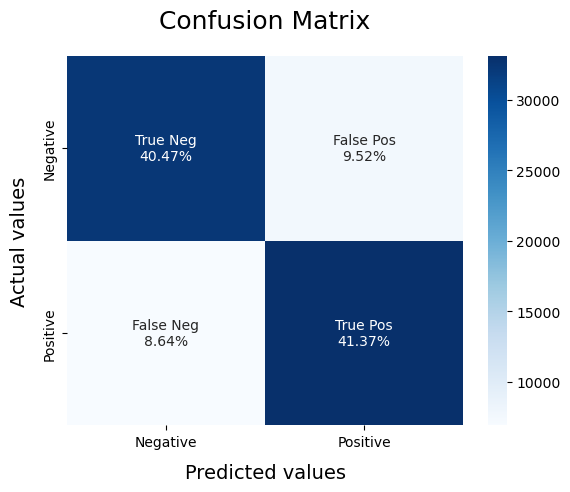

In [29]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
modelvaluate(SVCmodel)

Accuracy Score: 0.8284375
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



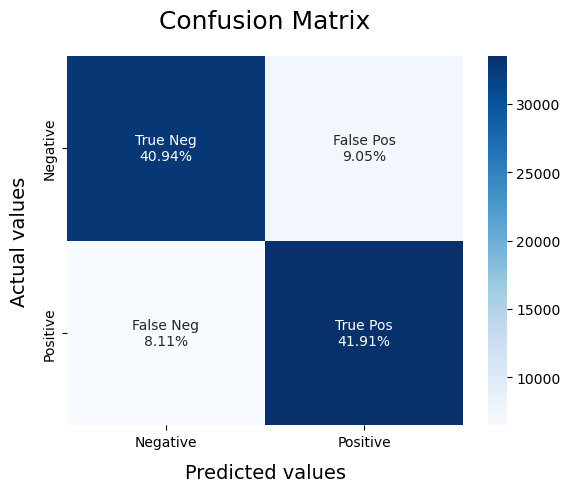

In [30]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
modelvaluate(LRmodel)

In [31]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [32]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('/Users/kumarmayank/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/Users/kumarmayank/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Text to classify should be in a list.
    text = ["I love twitter",
            "May I help you.",
            "I will banned everyone"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                     text sentiment
0          I love twitter  Positive
1         May I help you.  Positive
2  I will banned everyone  Negative
